In [9]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
from TESStools import *

In [3]:
tid = 179305185

Text(0, 0.5, 'Normalized Flux')

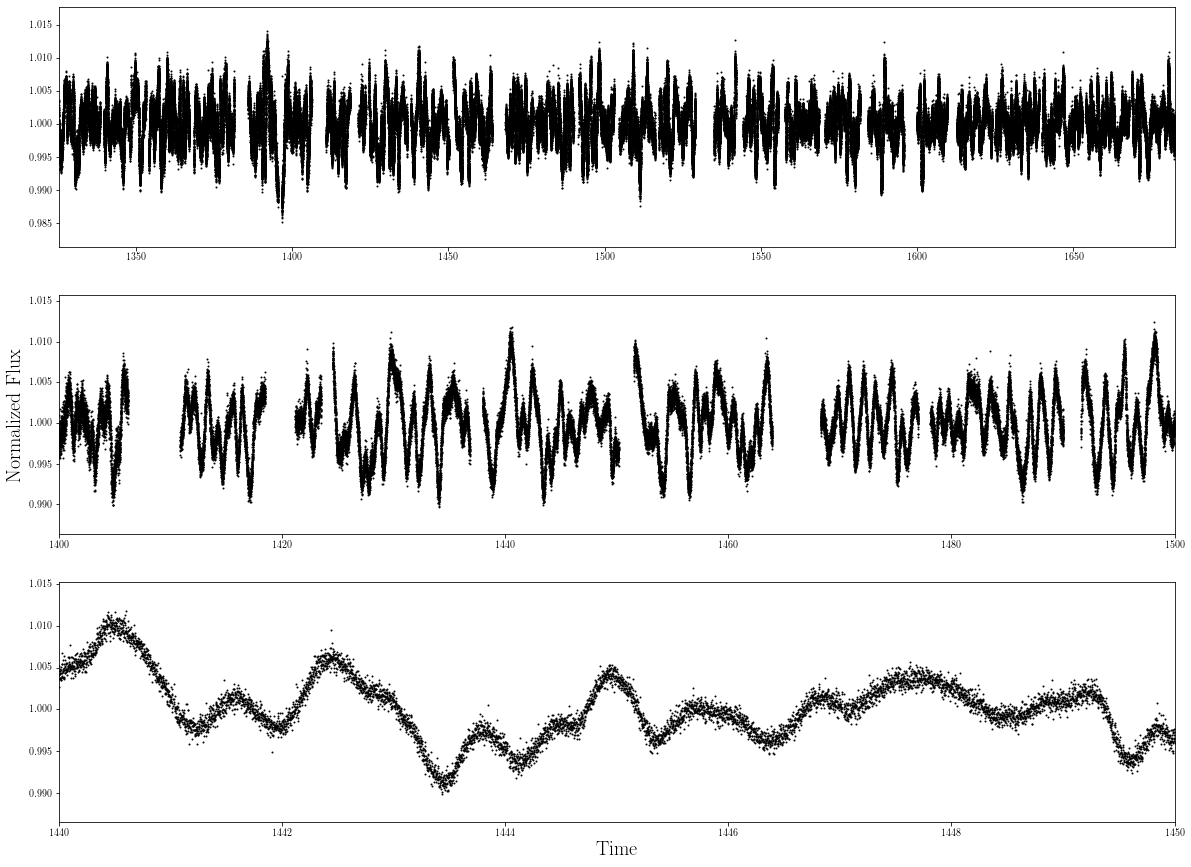

In [4]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
fig,ax = plt.subplots(nrows=3,figsize=(20,15))
ax[0].scatter(time,flux,s=1,c='k')
ax[1].scatter(time[(time > 1400)&(time < 1500)],flux[(time > 1400)&(time < 1500)],s=1,c='k')
ax[2].scatter(time[(time > 1440)&(time < 1450)],flux[(time > 1440)&(time < 1450)],s=1,c='k')

ax[0].set_xlim(np.min(time),np.max(time))
ax[1].set_xlim(1400,1500)
ax[2].set_xlim(1440,1450)

ax[2].set_xlabel('Time',fontsize=20)
ax[1].set_ylabel('Normalized Flux',fontsize=20)

Let's try some wavelet analysis here! Even though we're close to even sampling, classical wavelet transforms can pick up on timescales introduced by the sampling, and we want as clean a transform as possible. There's lots of options (e.g., Foster 1996, Frick 1997); we're going with the Weighted Wavelet Z-transform (WWZ), which is based on the abbreviated Morlet wavelet:

$\psi(t,\tau,\omega) = e^{i\omega(t-\tau)-c\omega^2(t-\tau)^2}$

where $c$ is chosen to be sufficiently small so that the Gaussian envelope of the wavelet decays appreciately over the course of one cycle $\omega/2\pi$. Here we adopt $c=0.0125$. A detailed presentation of the method is presented by Foster (1996, AJ, 112, 4).

The discrete wavelet transform can be converted into a projection onto the continuous basis functions

$\phi_1(t,\omega,\tau) = 1$

$\phi_2(t,\omega,\tau) = \cos{\omega(t-\tau)}$

$\phi_3(t,\omega,\tau) = \sin{\omega(t-\tau)}$

and we now fold the Gaussian envelope into a weighting function for each data point at time $t_\alpha$ that depends on the frequency and time-shift of the wavelet:

$w_\alpha = e^{-c\omega^2(t_\alpha-\tau)^2}$

In [5]:
#Let's put our functions in a list that we can loop over
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
#and finally a decay constant for the Gaussian envelope
c = 0.0125

The WWZ takes as a parameter the ${\rm\it effective}$ number of data points contributing to the transform at a given frequency/time, $N_{eff}$, which is the ratio of the square of the sum of the weights to the sum of the square of the weights.

Some notation: given two functions observed at times $\{t_\alpha\}$, we define the inner product of the two functions to be

$\langle f|g \rangle = \frac{\sum_{\alpha=1}^{N}w_\alpha f(t_\alpha)g(t_\alpha)}{\sum_{\beta=1}^{N}}$

We now define a matrix whose elements are the inner product of two of our basis functions

$S_{ab} = \langle \phi_a | \phi_b \rangle$

where $S$ here is a 3x3 symmetric matrix.

Now, we need to calculate the coefficient to each $\phi_a$, $y_a$, that reproduce the wavelet fit to the data $y$ at each $\omega$ and $\tau$, using

$y_\alpha = \sum_bS_{ab}^{-1}\langle\phi_b|y\rangle$

First, we make a convenience function that makes a column vector $y_{b}$ where the $i^{\rm th}$ entry is $\langle\phi_i|y\rangle$:

With this function, we can now write each $y_a$ as the $i^{\rm th}$ entry in the vector formula

$\vec{y_\phi} = S^{-1}\vec{y_b}$

Matrix inversion gets numerically stable for very small or very large values. We rewrite the right-hand-side of the equation as

$S^{-1}\vec{y_b} = \vec{x}$

which is the solution to the vectory equation

$\vec{y_b} = S\vec{x}$

which allows us to use numerically stable algorithms for solving matrix equations:

We now define two quanitites that help us compare the data and the model. First, the weighted variation of the data,

$V_x = \langle x|x\rangle - \langle \phi_1 | x\rangle^2$

and the weighted variation of the model,

$V_y = \langle y|y\rangle - \langle \phi_1 | y\rangle^2$

where $y = \vec{y_\phi}\cdot\vec{\phi}$ where $\vec{y_\phi}$ are the coefficients to the set of basis functions $\vec{\phi}$.

Now, with these ingredients, we can calculate the Weighted Wavelet Z-transform at a given $\omega$, $\tau$ as

$WWZ = \frac{(N_{eff} - 3) V_y}{2(V_x-V_y)}$

We will also calculate the Weighted Wavelet Amplitude, which is the coefficients of the sinusoidal basis functions added in quadrature:

$WWA = \sqrt{y_2^2 + y_3^3}$

In [23]:
#Let's try it!
y = flux.values
t = time.values
omega_start = -3 #nu ~ 0.02
omega_end = 3.5 #nu ~ 1.8
omegas = np.logspace(omega_start,omega_end,1000,base=2)
taus = np.linspace(np.min(t),np.max(t),500)
wwz,wwa = MP_WWZ(func_list,f1,y,t,omegas,taus,c=c)

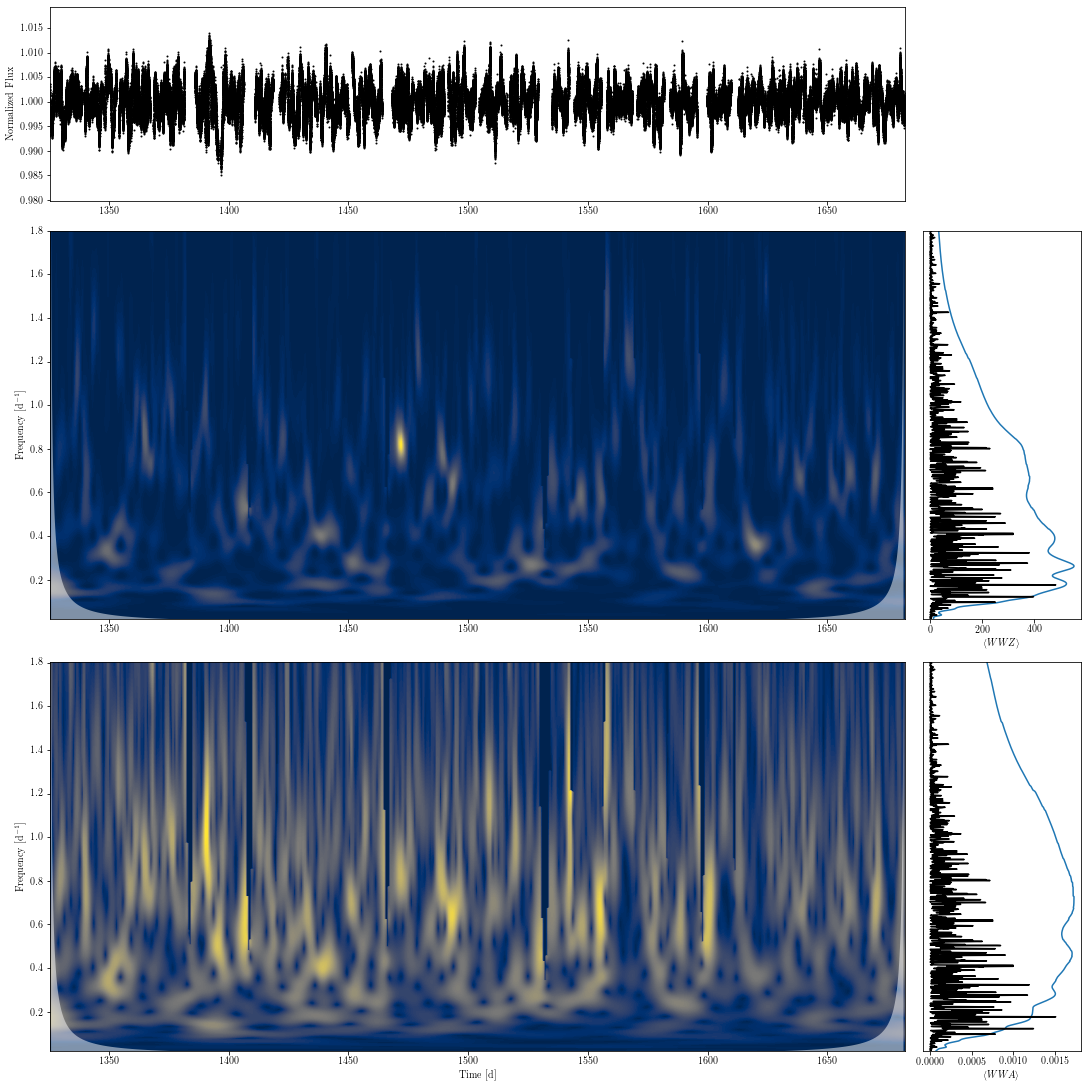

In [24]:
ls = LombScargle(t,y)
freq,power = ls.autopower()

fig = plt.figure(constrained_layout=True,figsize=(15,15))

gs = GridSpec(5, 4, figure=fig)
lcax = fig.add_subplot(gs[0, :3])
wwzax = fig.add_subplot(gs[1:3,:3])
wwaax = fig.add_subplot(gs[3:,:3])
zsumax = fig.add_subplot(gs[1:3,3])
asumax = fig.add_subplot(gs[3:,3])

lcax.scatter(time,flux,s=1,c='k')
lcax.set(ylabel='Normalized Flux',xlim=(np.min(time),np.max(time)))

wwzax.contourf(taus,omegas/2.0/np.pi,wwz,levels=100,cmap='cividis')
wwzax.fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwzax.set(ylabel=r'Frequency [d$^{-1}$]',ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))

wwaax.contourf(taus,omegas/2.0/np.pi,wwa,levels=100,cmap='cividis')
wwaax.fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwaax.fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
wwaax.set(xlabel='Time [d]',ylabel=r'Frequency [d$^{-1}$]',ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))

zsumax.plot(np.mean(wwz,axis=1),omegas/2.0/np.pi)
scale = np.max(np.mean(wwz,axis=1))/np.max(power)
zsumax.plot(power*scale,freq,c='k')
zsumax.set(yticks=[],xlabel=r'$\langle WWZ \rangle$',
           ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))

asumax.plot(np.mean(wwa,axis=1),omegas/2.0/np.pi)
asumax.set(yticks=[],xlabel=r'$\langle WWA \rangle$',
           ylim=(np.min(omegas)/2/np.pi,np.max(omegas/2/np.pi)))
scale = np.max(np.mean(wwa,axis=1))/np.max(power)
asumax.plot(power*scale,freq,c='k')

(0.0006917802274330079, 0.005097560379148561)

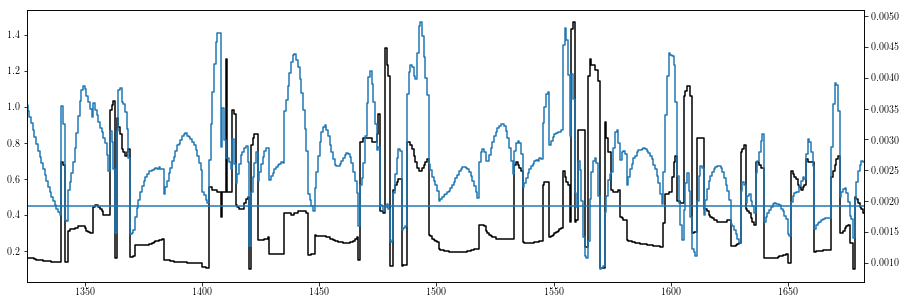

In [12]:
fig = plt.figure(figsize=(15,5))
plt.step(taus,np.array(max_peak_WWZ)/2.0/np.pi,c='k',where='mid')
plt.axhline(y=0.45)
ax = plt.gca().twinx()
ax.step(taus,max_peak_WWA,where='mid')
yl = ax.get_ylim()
plt.xlim(np.min(taus),np.max(taus))
plt.ylim(0,2.5)
ax.set_ylim(yl)

(0, 0.006)

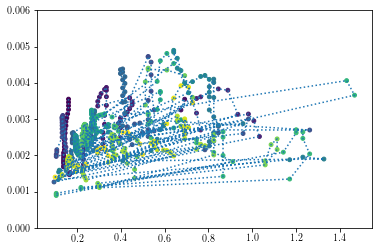

In [13]:
plt.plot(np.array(max_peak_WWZ)/2/np.pi,max_peak_WWA,ls=':')
plt.scatter(np.array(max_peak_WWZ)/2/np.pi,max_peak_WWA,c=taus,s=15)
plt.ylim(0,0.006)

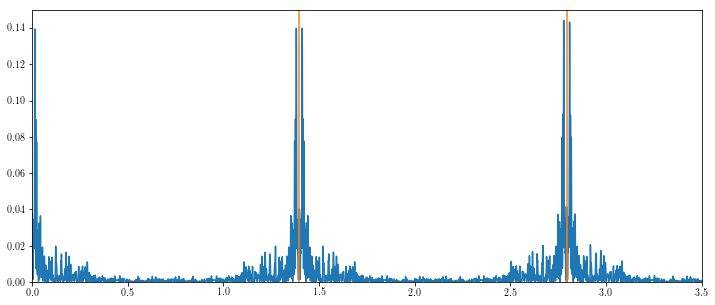

In [14]:
fig = plt.figure(figsize=(12,5))
ls = LombScargle(taus,max_peak_WWZ)
f,p = ls.autopower()
plt.plot(f,p)
plt.xlim(0,3.5)
plt.ylim(0,0.15)
plt.axvline(x=1.398,c='C1')
plt.axvline(x=2*1.398,c='C1')

/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


(6.210417079248738e-08, 0.15)

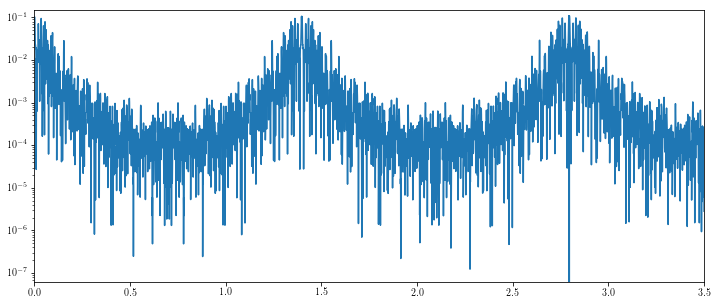

In [15]:
fig = plt.figure(figsize=(12,5))
ls = LombScargle(taus,max_peak_WWA)
f,p = ls.autopower()
plt.semilogy(f,p)
plt.xlim(0,3.5)
plt.ylim(0,0.15)
#plt.axvline(x=1.398,c='C1')
#plt.axvline(x=2*1.398,c='C1')

212510

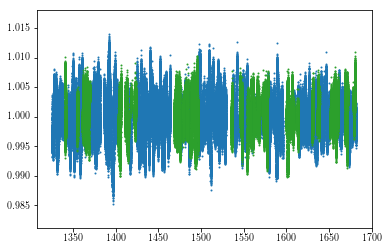

In [129]:
#bin observations into tau time bins
tau_bins = taus + 0.5*np.diff(taus)[0]
bindices = np.digitize(time,tau_bins)

#Assign time True or False if omega of that bin is > or < 0.45
flare_bool = np.array(max_peak_WWZ)[bindices]/2/np.pi > 0.45
t_lo, f_lo = time[~flare_bool], flux[~flare_bool]
t_hi, f_hi = time[flare_bool], flux[flare_bool]
plt.scatter(t_lo,f_lo,s=1,c='C0')
plt.scatter(t_hi,f_hi,s=1,c='C2')

In [158]:
ls = LombScargle(time,flux)
ls_lo = LombScargle(t_lo,f_lo)
ls_hi = LombScargle(t_hi,f_hi)
freq,power = ls.autopower()
freq_lo,pow_lo = ls_lo.autopower()
freq_hi,pow_hi = ls_hi.autopower()

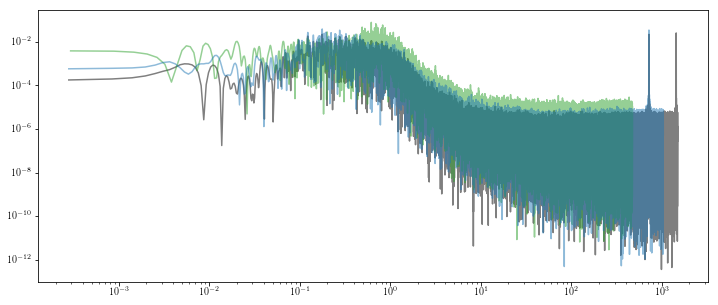

In [159]:
fig = plt.figure(figsize=(12,5))
plt.loglog(freq,power,c='k',alpha=0.5)
plt.loglog(freq_hi,pow_hi,c='C2',alpha=0.5)
plt.loglog(freq_lo,pow_lo,c='C0',alpha=0.5)

(0, 1.0)

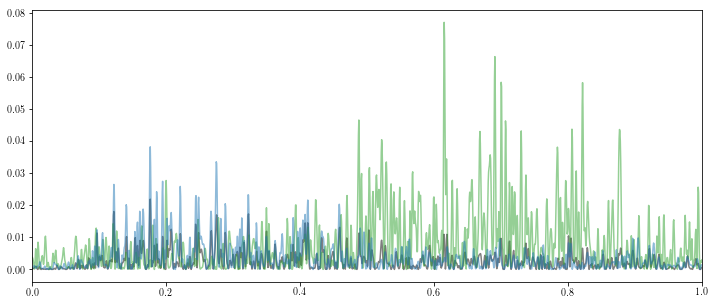

In [162]:
fig = plt.figure(figsize=(12,5))
plt.plot(freq,power,c='k',alpha=0.5)
plt.plot(freq_hi,pow_hi,c='C2',alpha=0.5)
plt.plot(freq_lo,pow_lo,c='C0',alpha=0.5)
plt.xlim(0,1.0)

(0, 0.03)

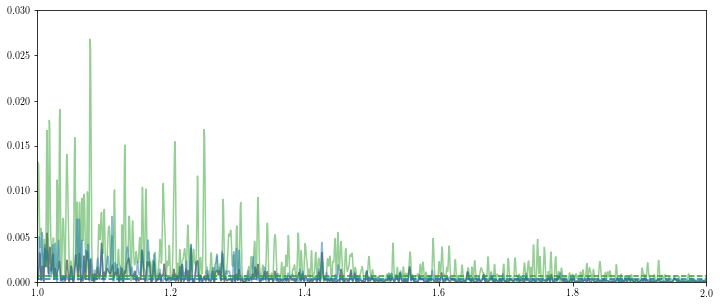

In [168]:
fig = plt.figure(figsize=(12,5))
plt.plot(freq,power,c='k',alpha=0.5)
plt.plot(freq_hi,pow_hi,c='C2',alpha=0.5)
plt.plot(freq_lo,pow_lo,c='C0',alpha=0.5)
plt.axhline(ls_lo.false_alarm_level(0.001),c='C0',ls='--')
plt.axhline(ls_hi.false_alarm_level(0.001),c='C2',ls='--')
plt.xlim(1,2.0)
plt.ylim(0,0.03)

(715, 725)

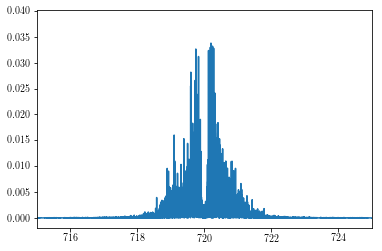

In [144]:
plt.plot(freq_lo,pow_lo)
plt.xlim(715,725)

/Users/carina/anaconda/lib/python3.5/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


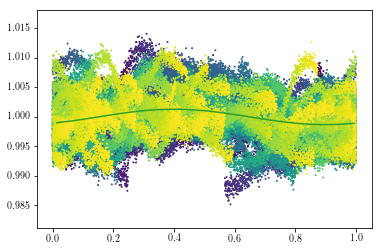

In [156]:
best_frequency = freq_lo[freq_lo>700][np.argmax(pow_lo[freq_lo>700])]
t_fit = np.linspace(np.min(t_lo), np.min(t_lo)+1.0/best_frequency)
y_fit = ls_lo.model(t_fit, best_frequency)
p_fit = (t_fit * best_frequency) % 1
fit_sort = np.argsort(p_fit)
phase_lo = (t_lo * best_frequency) % 1
psort = np.argsort(phase_lo)
plt.scatter(phase_lo[psort],f_lo[psort],s=1,c=t_lo)
plt.plot(p_fit[fit_sort],y_fit[fit_sort],c='C2')

In [119]:
print(min(tau_bins),min(taus),max(tau_bins),max(taus))

1324.9384317318934 1325.296208223915 1682.7149237536007 1682.357147261579


In [66]:
#sliding window periodogram
def sliding_periodogram(time, flux, err=None, window=15.0, dt=1.0, max_f=5.0):
    """
    A sliding window periodogram. Calculated over a window of width `window` days,
    every `dt` days
    
    Parameters
    ----------
    time : array-like
        times
    flux : array-like
        fluxes
    err : array-like
        errors, optional
    window : float
        width of sliding window
    dt : float
        size of step over the window
    max_f : float
        maximum frequency to calculate the Lomb-Scargle periodogram
        
    Returns
    -------
    ts : array-like
        Time values of sliding periodogram
    freq : array-like
        Frequency grid of `periodograms`
    periodograms : array-like
        Periodograms. Each entry is a periodogram corresponding to a time in `ts`. Shape is
        `(len(ts),len(freq))`
    
    """
    
    min_t = np.min(time)#+(window/2.0)
    max_t = np.max(time)#-(window/2.0)
    
    n_dt = np.floor((max_t-min_t) / dt)
    start = min_t
    stop = min_t+(n_dt*dt)
    num = int(n_dt+1)
    ts = np.linspace(start,stop,num=num)
    periodograms = []
    for i,t in enumerate(ts):
        condition = (time >= t-(window/2.0))&(time < t+(window/2.0))
        wtime = time[condition]
        wflux = flux[condition]
        if err is not None:
            werr = err[condition]
            ls = LombScargle(wtime,wflux,dy=werr)
        else:
            ls = LombScargle(wtime,wflux)
        if i == 0:
            freq,power = ls.autopower(maximum_frequency=max_f)
        else:
            power = ls.power(freq)
        periodograms.append(power)
    periodograms = np.array(periodograms)
    
    return ts, freq, periodograms

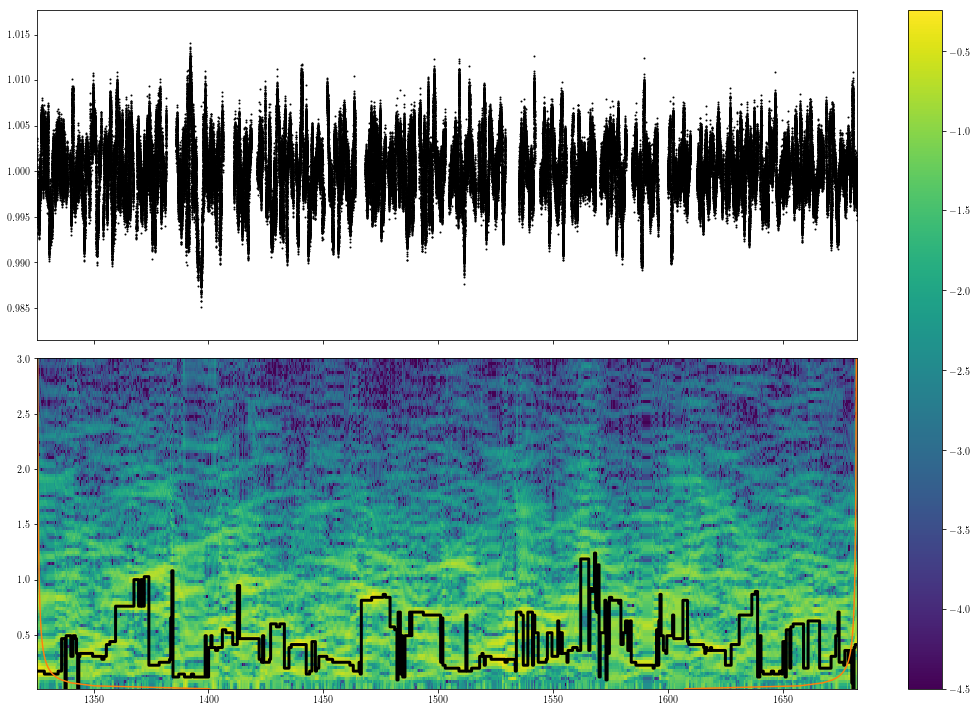

In [67]:
ts, freq, periodograms = sliding_periodogram(time,flux,err,window=15.0,dt=0.5,max_f=3.0)
fig,ax = plt.subplots(2,figsize=(15,10),sharex=True)
ax[0].scatter(time,flux,s=1,c='k')
mesh = ax[1].pcolormesh(ts,freq,np.log10(periodograms.T),vmin=-4.5)
ax[0].set(xlim=(min(time),max(time)))
max_peak = [freq[p==m][0] if not np.isnan(m) else np.nan for p,m in zip(periodograms,np.max(periodograms,axis=1))]
ax[1].step(ts,max_peak,c='k',lw=3,where='mid')
ax[1].plot(1.0/freq+np.min(time),freq,c='C1')
ax[1].plot(np.max(time)-1.0/freq,freq,c='C1')
fig.tight_layout()
plt.colorbar(mappable=mesh,ax=ax)

/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


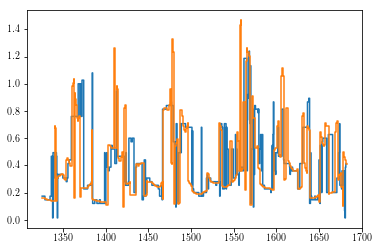

In [70]:
plt.step(ts,max_peak,ls='-',where='mid')
plt.step(taus,np.array(max_peak_WWZ)/2/np.pi,ls='--',where='mid')

(array([  6., 101., 136.,  89.,  97.,  65.,  39.,  35.,  55.,  43.,  26.,
          4.,   9.,   2.,   8.]),
 array([0.01333575, 0.09512838, 0.17692101, 0.25871364, 0.34050627,
        0.4222989 , 0.50409153, 0.58588416, 0.66767679, 0.74946942,
        0.83126205, 0.91305467, 0.9948473 , 1.07663993, 1.15843256,
        1.24022519]),
 <a list of 15 Patch objects>)

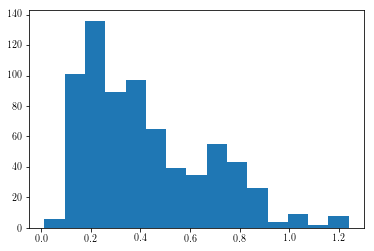

In [6]:
plt.hist(max_peak,bins='auto')

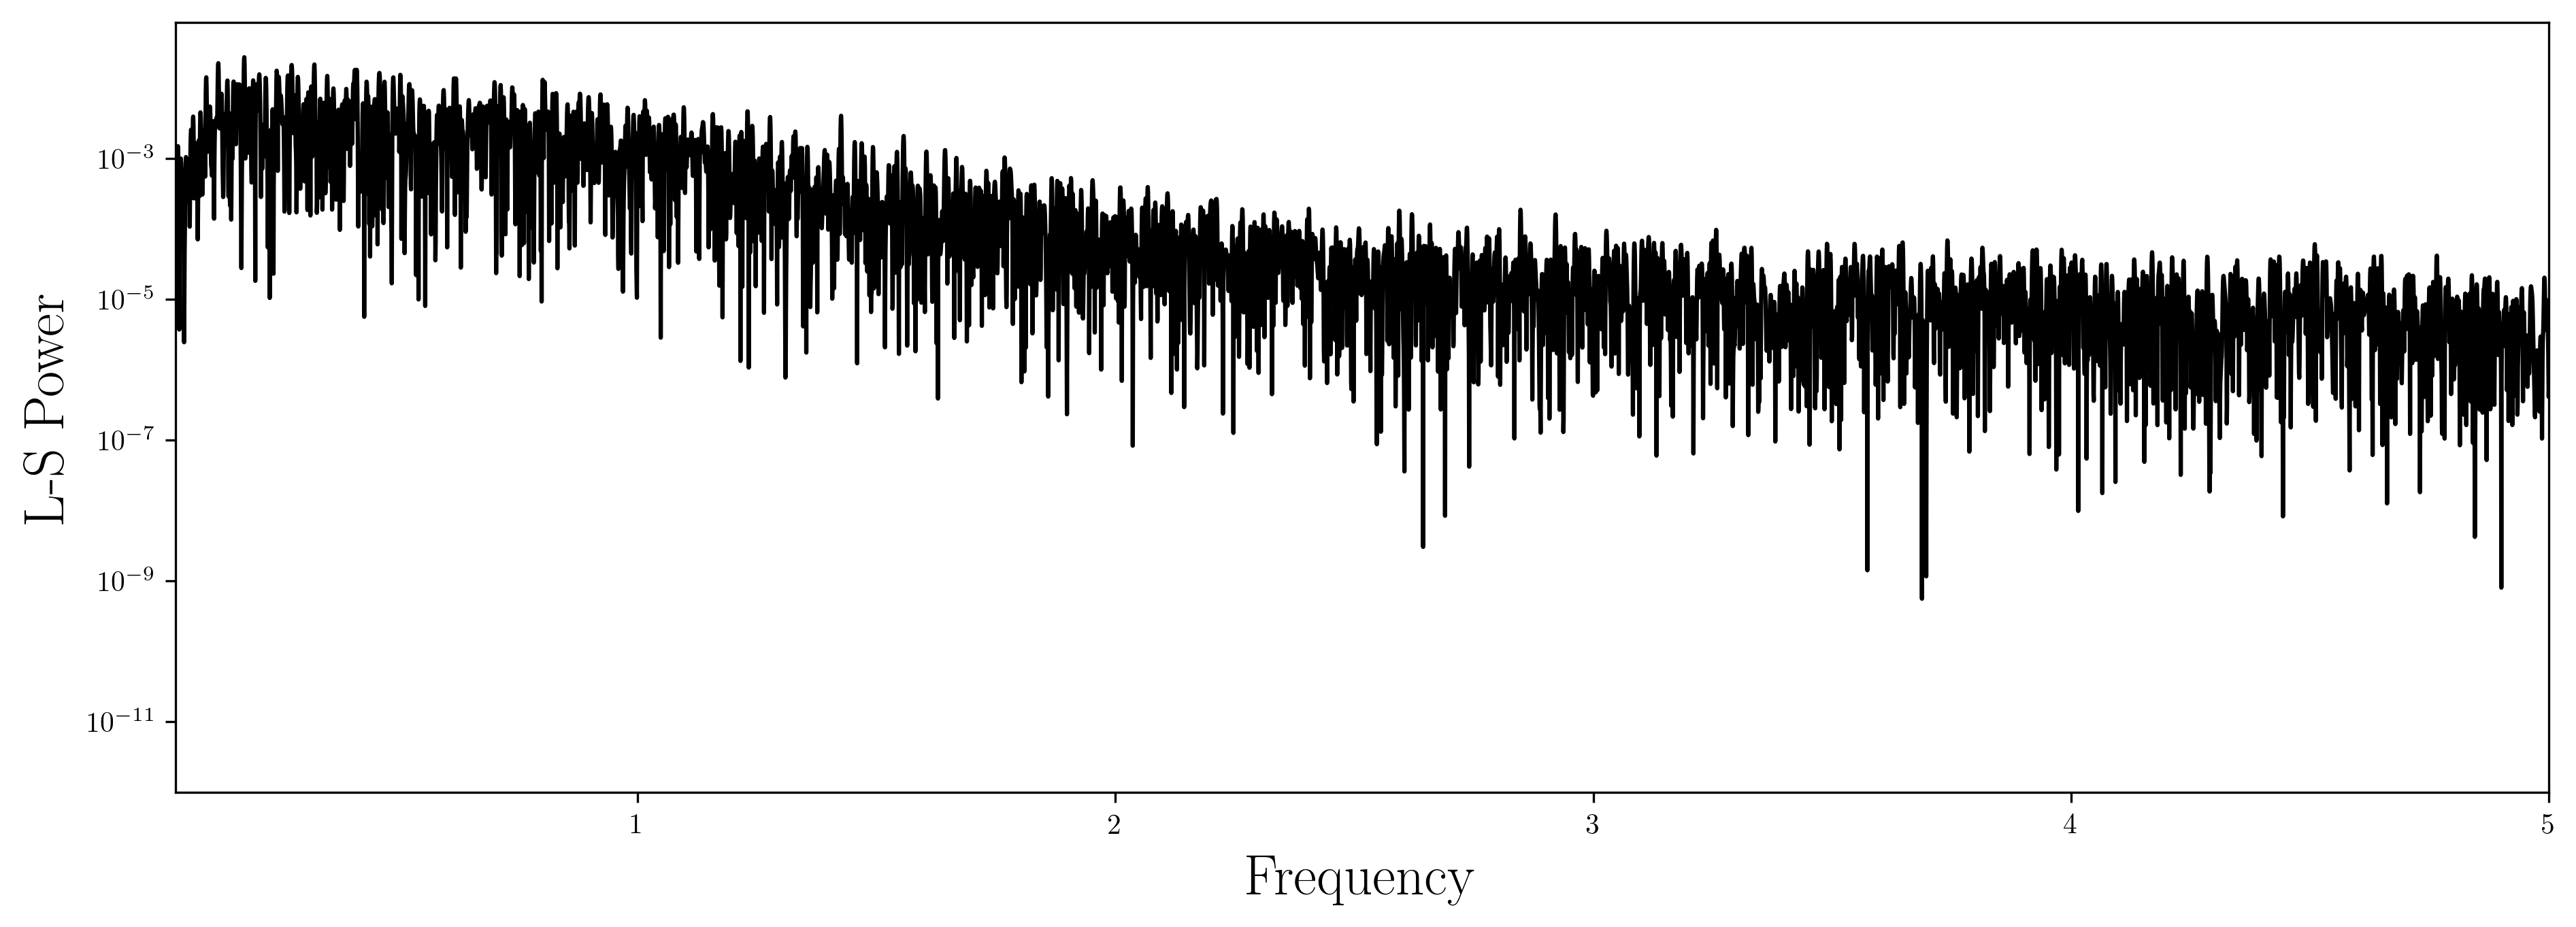

In [79]:
fig = plt.figure(figsize=(15,5),dpi=300)
pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 
plt.plot(freq,power,c='k')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(1/30,5)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('L-S Power',fontsize=20)
plt.savefig('/Users/carina/Desktop/sdorgram.png')

In [3]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)
harmonics = harmonic_search(good_fs)
combos = combo_search(good_fs)

f_Ny = 322.8060468379108, f_R = 0.0177879072510214
10
20
30
40
50
60
70
Found 71 frequencies
41 unique frequencies


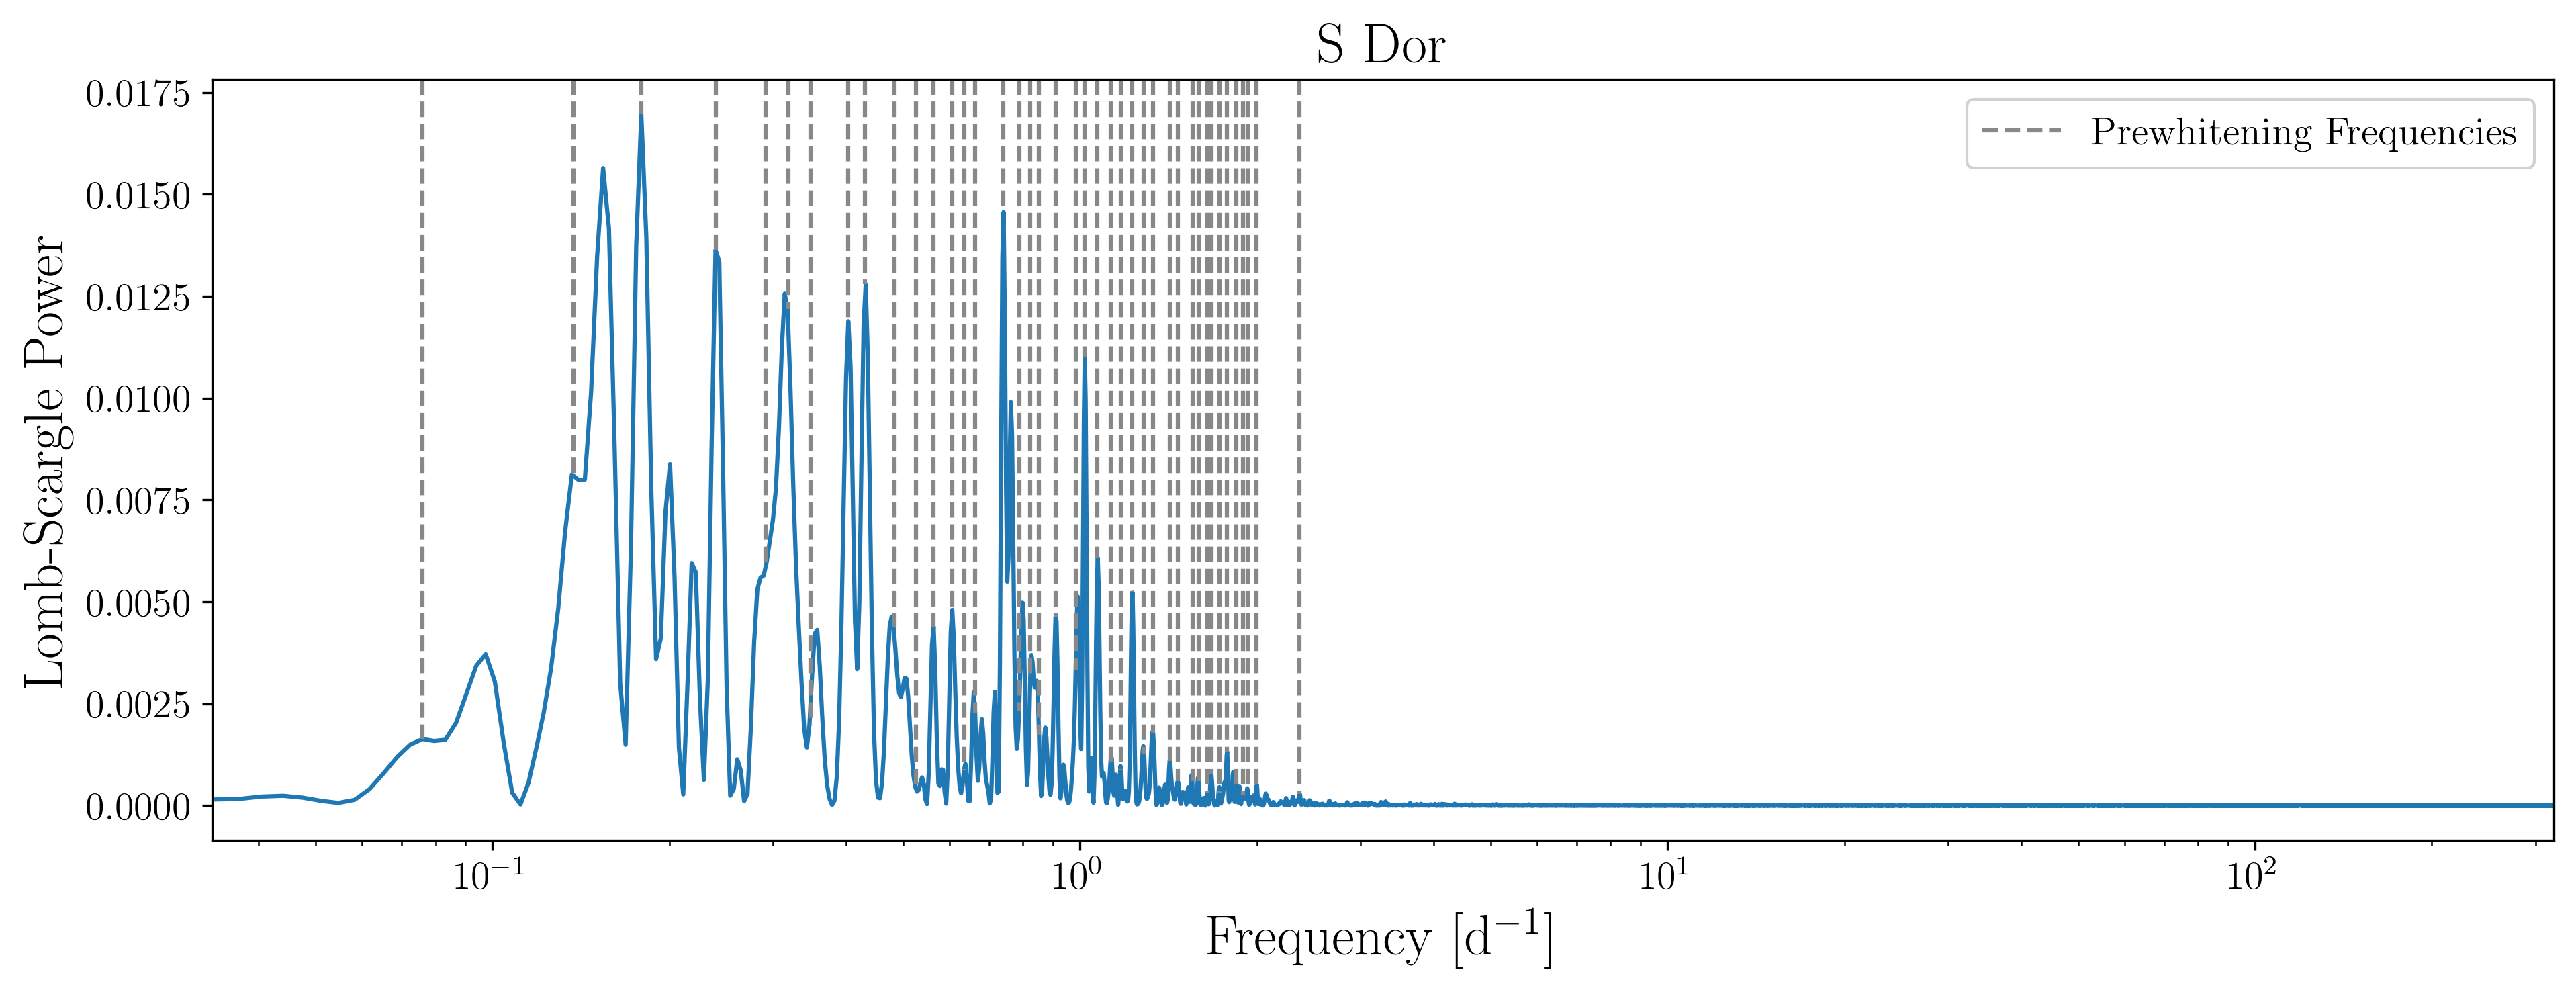

In [4]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
       
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
ax.set_title('S Dor',fontsize=20) 
plt.savefig('../plots/SDor_periodogram.pdf')

/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:133: RuntimeWarning: invalid value encountered in true_divide
  ACF /= M
/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:135: RuntimeWarning: divide by zero encountered in true_divide
  return ACF, np.sqrt(2. / M), bins
/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:73: RuntimeWarning: invalid value encountered in greater
  if np.all(p[i] > p[i -width:i])&np.all(p[i] > p[i + 1:i+width+1])&(p[i]>FAL):


[0.08194736 0.25312258 0.16582783 0.58976342 0.44486563]


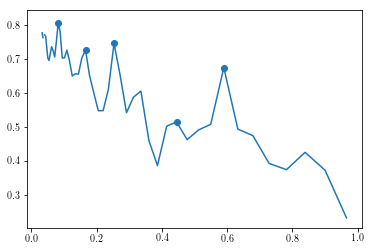

In [5]:
C_EK, C_EK_err, bins = ACF_EK(freq[freq<=2], power[freq<=2], 0.001*power[freq<=2], bins=np.logspace(-1.5, 0, 50))
f_EK = 0.5 * (bins[1:] + bins[:-1])
plt.plot(f_EK,C_EK)
f,p = peak_finder(f_EK,C_EK,10,width=3)
plt.scatter(f,p)
print(f)

In [6]:
harmonics

array([[0.07590602],
       [0.60660139],
       [8.        ]])

In [7]:
combos

array([[0.17914669, 0.17914669, 0.40287251, 0.13744498, 0.48307755,
        0.98355185, 0.98355185, 0.63478994],
       [0.48307755, 1.46672799, 1.01866464, 0.52554769, 0.98355185,
        0.60660139, 0.66258409, 1.72867338],
       [0.66258409, 1.6460147 , 1.42147429, 0.66258409, 1.46672799,
        1.59025206, 1.6460147 , 2.36401361]])

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


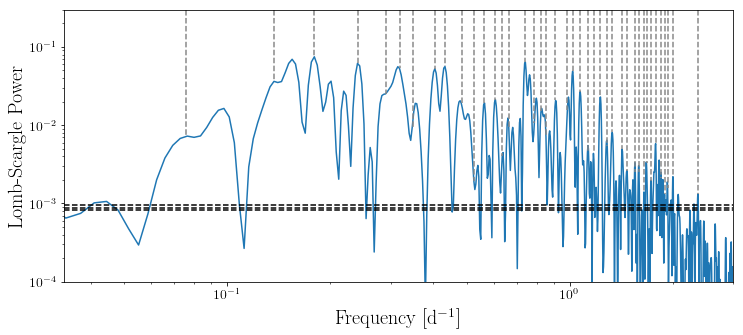

In [11]:
fig = plt.figure(figsize=(12,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
lc = polynorm(lc, deg=7)[0]
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time, flux)
freq, power = ls.autopower() 
plt.loglog(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]',ylabel='Lomb-Scargle Power', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
   
ax.set(ylim=(1e-4,ylim[1]))
ax.set(xlim=(1/30,3))

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities)
for f in fal:
    plt.axhline(y=f,c='k',ls='--')
        
#plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

In [13]:
good_fs[:,0][~np.array([power[np.argmin(np.abs(freq-f))] for f in good_fs[:,0]] >= fal[-1])]

array([], dtype=float64)